## Goal

The goal of this notebook is to utilize the annotations dataset to predict the type of image quality issues given the provided annotations. This will allow us to predict what type of image quality issues we will encounter, if human/automated reporter attaches specific annotations to the image. The data utilized in this analysis comes from the VizWiz dataset, which is a compilation of images taken by users who are partially blind or fully blind. This gives us insight into the types of issues associated with the images taken in the course of the research done at VizWiz.

#### TODOS:

-- Simulate feedback on blind photos in wizard of oz hci experiments (where the feedback is "simulated", it seems real, but it isn't)
--- Use machine learning to be able to simulate feedback

##### Imports (Misc and ML)

In [60]:
# imports used for ML purposes
from sklearn.linear_model import LinearRegression
import pandas as pd

# imports used for graphing purposes
import plotly.express as pe
import seaborn as sns
import matplotlib.pyplot as plt

# misc imports used for structural integrity
import json
from dataclasses import dataclass
from enum import Enum
from typing import Optional

##### Structural Class Declarations

In [61]:
class FlawsEnum(Enum):
    """
    Represents the varying types of flaws a picture can experience when being taken
    """
    BLURRY = "BLR",
    BRIGHTNESS = "BRT",
    DARK = "DRK",
    FRAME = "FRM",
    NON_CLEAR = "NON",
    OBSTRUCTION = "OBS",
    OTHER = "OTH",
    ROTATION = "ROT"


In [62]:
@dataclass
class AnnotationData:
    """
    Class representing the JSON data being parsed in the dataset
    """
    flaws: dict[FlawsEnum, int] # The types of flaws present in the database
    image: str # The link of the image
    unrecognizable: int # Whether the image is unrecognizable

In [63]:
data: Optional[list[AnnotationData]]
with open("./data/train.json") as training_data:
    data: list[AnnotationData] = json.load(training_data)

print(data[0])

{'flaws': {'FRM': 1, 'BLR': 5, 'DRK': 0, 'BRT': 3, 'OBS': 0, 'OTH': 0, 'NON': 0, 'ROT': 0}, 'image': 'VizWiz_train_00022585.jpg', 'unrecognizable': 4}


### 0. Dataset Creation

In [64]:
# normalizes json, taking in the json object, and constructing a df of the json normalized (all the subfields made into parent_child_childchild_etc, and the root attributes not separated by the `sep` argument)
normalized_df = pd.json_normalize(data, sep='_').drop(columns=['image'])

target = normalized_df['unrecognizable']
data_df = normalized_df.drop(columns=['unrecognizable'])


### 1. Feature Selection

#### 1.1 Domain Knowledge

I don't have too much domain knowledge on issues pertaining to blind users taking pictures, and the commonality of issues associated with that. That domain knowledge will grow as I parse through the dataset to analyze the commonality of certain quality issues. I cannot make a certain distinction whether specific features need to be removed. I can revisit this question later on in the process to determine if any features need to be removed.

#### 1.2 Correlation Analysis

<Axes: >

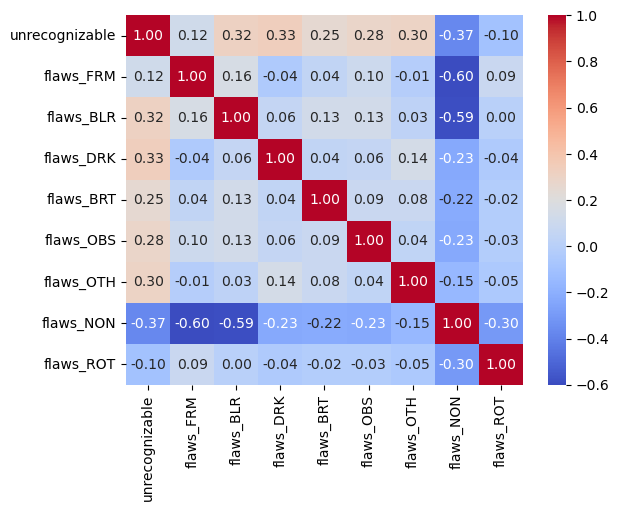

In [66]:
corr_matrix = normalized_df.corr() # The correlation matrix with the full data, which is used to find positive/negative correlation among features in the dataset

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

#### Observations

Judging from this dataset, we can see that most of the flaws have close to .5 positive correlation with the unrecognizable attribute. Which logically thinking, if an image is blurry/dark, it is most likely going to be unrecognizable. The NON_CLEAR flaw present in the images (`flaws_NON`) has substantially lower correlation to the image being unrecognizable then any of the other features present in the dataframe. 

##### *Observation of flaws_NON*

This may lead me to believe that when the image was flagged with NON_CLEAR, it was less that the image itself had flaws, it was just unclear if the image was even going to be considered for recognition, since it was completely different then what was requested.

For example, presume I take a picture of medication, for review, and I pose the question as "What brand of chips is this?", the reviewer does not see the image as unrecognizable, because the recognition step is not activated due to the image being completely divergent from the question. Thus the flaw `flaws_NON` is added to the image.

##### *Observation of flaws_DRK*

We can see from the correlation matrix that flaws_DRK contains the highest positive correlation with unrecognizable images. I am a bit skeptical about flaws_BRT being lower then flaws_DRK, although I assume it is just because it is easier to deduce what an image is if it's more bright then more dark, because some of the image is still visible, just extremely bright. The darkness hides the image, making it difficult to tweak the image to make it recognizable.

#### 1.3 Feature Importance

We can easily test the feature importance by plugging the data into a LinearRegression model and creating a new dataframe from the columns and the model coefficients.

##### 1.3.1 Linear Regression (Simple Model)

In [69]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(data_df, target)

feature_importance = pd.DataFrame({ 'Feature': data_df.columns, 'Coefficient': model.coef_ })

feature_importance

,Feature,Coefficient
0,flaws_FRM,0.004903
1,flaws_BLR,0.121409
2,flaws_DRK,0.377167
3,flaws_BRT,0.261277
4,flaws_OBS,0.371227
5,flaws_OTH,0.772806
6,flaws_NON,-0.101241
7,flaws_ROT,-0.113384


**Observations**

As we can see from the LinearRegression model implementation, we can see that the features with the highest level of correlation in the LinR model are `flaws_OTH`, and the features with the lowest level of correlation are `flaws_ROT`. These are interesting finds, and let's see if the correlation structure reappears in the next few models we will be testing for feature importance.

**Thoughts**

These results contradict what my presumption was about which features caused major issues recognizing the image. I was under the presumption that `flaws_OTH` would have the least correlation with `unrecognizable`, but in the LinR model, `flaws_OTH` has a high correlation to `unrecognizable`. Logically, this does not seem correct, and this line of thinking is reinforced by the earlier correlation plot shown above. If a image has an `Other` reason as the flaw with it, I assume that the `Other` option is not selected as frequently as the other flaw options are.

##### 1.3.2 RandomForest Regressor

In [72]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
model_rf.fit(data_df, target)

feature_importance_rf = pd.DataFrame({ 'Feature': data_df.columns, 'Importance': model_rf.feature_importances_ })

feature_importance_rf

,Feature,Importance
0,flaws_FRM,0.113509
1,flaws_BLR,0.115933
2,flaws_DRK,0.154217
3,flaws_BRT,0.086958
4,flaws_OBS,0.126758
5,flaws_OTH,0.068124
6,flaws_NON,0.232668
7,flaws_ROT,0.101834


**Observations**

As we can see from these results, this is not quite similar to the LinR (Linear Regression) results, as the `flaws_OTH` and `flaws_ROT` are not the highest/lowest correlation features. The highest correlation feature is `flaws_NON`, which goes against the original correlation matrix we generated (from using the `.corr()` method on the full dataset). The statement still holds however, that the correlation output is not similar to the LinR output. The lowest correlation feature is `flaws_OTH`, which was the highest correlation in the LinearRegression output.

**Thoughts**

My initial presumption would be that `flaws_DRK` or `flaws_BLR` would have the highest correlation, logically those are major flaws that cause high unrecognizable values. Since if a picture is intensely dark, the picture would be extremely unrecognizable.

##### 1.3.2 Lasso Regression


In [75]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha=0.1)
model_lasso.fit(data_df, target)

feature_importance = pd.DataFrame({ 'Feature': data_df.columns, 'Coefficient': model_lasso.coef_ })

feature_importance

,Feature,Coefficient
0,flaws_FRM,-0.000000
1,flaws_BLR,0.082237
2,flaws_DRK,0.247499
3,flaws_BRT,0.091408
4,flaws_OBS,0.127747
5,flaws_OTH,0.000000
6,flaws_NON,-0.157703
7,flaws_ROT,-0.082785


**Observations**

The highest correlation feature is `flaws_DRK` and the lowest is `flaws_NON`. These are exactly the finds I wanted to see when testing out different models, and their correlation matrices. This is the correlation structure that most closely resembles the original correlation matrix generated with the seaborn module and the dataframe object.

**Thoughts**

These results match the correlation matrix originally generated in [this section](#1.2-correlation-analysis). This might be a good model to fit the annotation data. As this model presents the most logically 

##### 1.3.3 Gradient Boosting Regression

In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()